In [2]:
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from lhotse import CutSet, Fbank, LilcomFilesWriter
from lhotse.augmentation import SoxEffectTransform, RandomValue, pitch, reverb, speed
from lhotse.dataset import VadDataset, K2SpeechRecognitionDataset, vis
from lhotse.dataset.sampling import SingleCutSampler
from lhotse.recipes.librispeech import download_librispeech, prepare_librispeech

# Data parts

In [3]:
dataset_parts = 'mini_librispeech'
dev_set = 'dev-clean-2'
train_set = 'train-clean-5'

# Paths

In [4]:

root_dir = Path('data')
corpus_dir = root_dir / 'LibriSpeech'
output_dir = root_dir / 'librispeech_nb'

# Download and untar

In [46]:
download_librispeech(root_dir, dataset_parts, alignments=True)

Downloading...
From: https://drive.google.com/uc?id=1WYfgr31T-PPwMcxuAq09XZfHQO5Mw8fE
To: /Users/joannarownicka/software/vad/evaluation/data/LibriSpeech-Alignments.zip
71.7MB [00:39, 1.80MB/s]


# Prepare audio and supervision manifests

In [5]:
num_jobs = os.cpu_count()

In [6]:
librispeech_manifests = prepare_librispeech(corpus_dir, dataset_parts, output_dir, num_jobs=num_jobs)

Dataset parts: 100%|██████████| 2/2 [00:00<00:00, 341.17it/s]


# [Optional] Data augmentation

In [7]:
use_data_augmentation = False
augment_fn = SoxEffectTransform(effects=[
   ['reverb', 50, 50, RandomValue(0, 100)],
   ['remix', '-'],  # Merge all channels (reverb changes mono to stereo)
   ['rate', 16000],
]) if use_data_augmentation else None

# Extract features

In [8]:
for partition, manifests in librispeech_manifests.items():
    manifest_path = output_dir / f'cuts_{partition}.json.gz'
    if not manifest_path.is_file():
        with ProcessPoolExecutor(num_jobs) as ex:
            cut_set = CutSet.from_manifests(
                recordings=manifests['recordings'],
                supervisions=manifests['supervisions']
            )
            if use_data_augmentation:
                cut_set = cut_set + cut_set.perturb_speed(0.9) + cut_set.perturb_speed(1.1)
            cut_set = cut_set.compute_and_store_features(
                extractor=Fbank(),
                storage_path=f'{output_dir}/feats_{partition}',
                storage_type=LilcomFilesWriter,
                augment_fn=augment_fn,
                num_jobs=num_jobs,
                executor=ex
            )
        librispeech_manifests[partition]['cuts'] = cut_set
        cut_set.to_json(manifest_path)
    librispeech_manifests[partition] = CutSet.from_json(manifest_path)

# Make PyTorch Dataset

{'inputs': tensor([[[ -9.3438,  -9.4141, -10.5605,  ...,  -9.4023,  -9.3955,  -9.3591],
         [ -9.9530,  -9.8310, -11.4975,  ...,  -9.9759,  -9.6736,  -9.8484],
         [-12.4926, -11.2415, -10.6064,  ...,  -9.4111,  -9.0873,  -9.5797],
         ...,
         [-10.1812,  -9.6111, -10.6098,  ...,  -9.6105, -10.0822, -10.4617],
         [ -8.9994,  -9.2480, -10.9214,  ..., -10.1778,  -9.8474,  -9.9747],
         [-10.3939,  -9.0600,  -9.9322,  ...,  -9.5239,  -9.7812,  -9.5687]],

        [[ -9.1875,  -8.7368,  -9.4367,  ...,  -9.1142,  -9.0841,  -9.5598],
         [ -9.6736,  -8.4186,  -8.8504,  ...,  -8.7674,  -8.7513,  -8.7711],
         [ -9.5915,  -8.0694,  -8.7713,  ...,  -8.7352,  -8.7091,  -8.7390],
         ...,
         [-23.0259, -23.0259, -23.0259,  ..., -23.0259, -23.0259, -23.0259],
         [-23.0259, -23.0259, -23.0259,  ..., -23.0259, -23.0259, -23.0259],
         [-23.0259, -23.0259, -23.0259,  ..., -23.0259, -23.0259, -23.0259]],

        [[-10.6875, -12.0986, -12

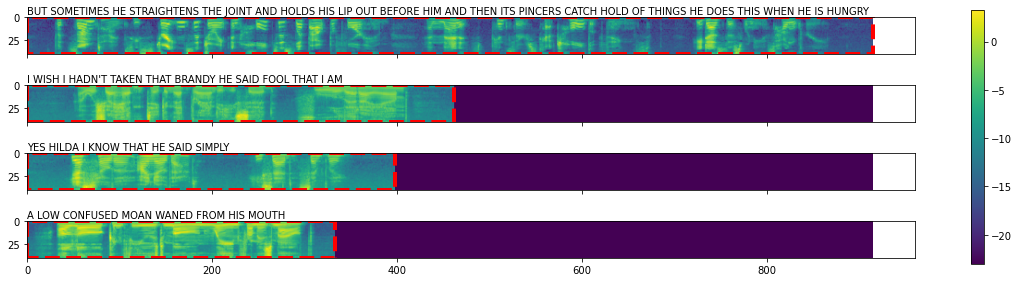

In [56]:
dataset_dev = K2SpeechRecognitionDataset(librispeech_manifests[dev_set])
dataset_train = K2SpeechRecognitionDataset(librispeech_manifests[train_set])

sampler = SingleCutSampler(librispeech_manifests[dev_set], shuffle=False, max_cuts=4)
cut_ids = next(iter(sampler))
sample = dataset_dev[cut_ids]

print(sample)
#print(cut_ids.simple_cuts)

vis.plot_batch(sample)

In [13]:
#dataset_dev = VadDataset(librispeech_manifests[dev_set])
#dataset_train = VadDataset(librispeech_manifests[train_set])

#sampler = SingleCutSampler(librispeech_manifests[dev_set], shuffle=False, max_cuts=4)
#cut_ids = next(iter(sampler))
#sample = dataset_dev[cut_ids]

#print(cut_ids.simple_cuts)
#print(sample)

vad_dataset = VadDataset(librispeech_manifests[dev_set].cut_into_windows(10.0, keep_excessive_supervisions=True))
sampler = SingleCutSampler(librispeech_manifests[dev_set], shuffle=False, max_cuts=4)
cut_ids = next(iter(sampler))
sample = vad_dataset[cut_ids]

TypeError: 'CutSet' object is not callable